# Task 2: Clustering

In [839]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the Customer Profile model

In [840]:
customer_profile = pd.read_csv('../dataset/customer_profile_model.csv', sep='\t', index_col=0)
customer_profile

,I,Iu,Imax,E,Savg,R,F,M
CustomerID,,,,,,,,
12747.0,6.674561,3.367296,4.941642,1.363873,5.475924,3.139833,4.174387,7.673149
12748.0,9.485925,7.273786,7.108244,1.317581,4.696793,1.410987,8.143517,9.784390
12749.0,7.110696,4.787492,6.439350,1.323402,6.305446,3.139833,4.990433,7.914884
12820.0,6.513230,3.988984,5.497168,1.202255,5.442006,3.808882,4.060443,6.828301
12821.0,4.219508,1.609438,4.219508,0.483616,4.327042,4.565389,1.609438,4.327042
...,...,...,...,...,...,...,...,...
18280.0,3.688879,2.079442,3.688879,0.409217,4.919981,5.075799,2.079442,4.919981
18281.0,3.951244,1.609438,3.951244,0.385909,3.848444,1.410987,1.609438,3.848444
18282.0,3.931826,2.079442,3.258097,1.047319,4.035390,5.375741,2.079442,4.728538


In [841]:
customer_profile = customer_profile.to_numpy()

## Standardization \& Dimensionality Reduction

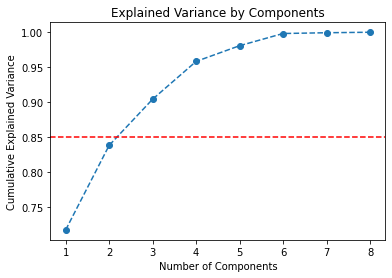

In [842]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
std_customer_profile = scaler.fit_transform(customer_profile)

pca = PCA()
pca.fit(std_customer_profile)

plt.plot(range(1, customer_profile.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.axhline(0.85, color='red', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

The graph shows the amount of variance captured depending on the number of components we include. A rule of thumb is to preserve around 80% of the variance. So, in this instance, we decide to keep 2 components.

In [843]:
pca = PCA(n_components=2)
pca_customer_profile = pca.fit_transform(std_customer_profile)

In [844]:
from sklearn.metrics import silhouette_score

## K-Means

In [845]:
from sklearn.cluster import KMeans

In [846]:
elbow = []
silhouette = []
for k in range(2, 10):
    kmeans = KMeans(init='k-means++', n_clusters=k)
    clusters = kmeans.fit_predict(pca_customer_profile)
    elbow.append(kmeans.inertia_)
    silhouette.append(silhouette_score(pca_customer_profile, clusters))

The elbow method only uses intra-cluster distances while the silhouette method uses a combination of inter- and intra-cluster distances. So, we can expect that they end up with different results.

### Silhouette method

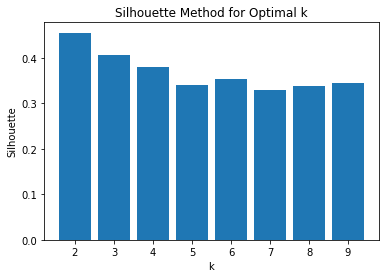

In [847]:
plt.bar(range(2, 10), silhouette)
plt.title('Silhouette Method for Optimal k')
plt.ylabel('Silhouette')
plt.xlabel('k');

In [848]:
print('The best silhouette score is:', max(silhouette))

The best silhouette score is: 0.455564436287944


In [849]:
kmeans = KMeans(init='k-means++', n_clusters=2)
clusters_customers = kmeans.fit_predict(pca_customer_profile)

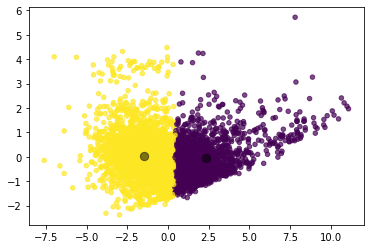

In [850]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7)
# select cluster centers
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [851]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,1,0
CustomersNb,2257,1425


For comparison, if we run only the k-means algorithm without the PCA step, the result would be the following:

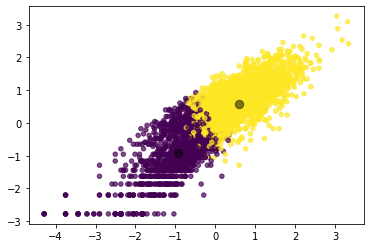

In [852]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7)
# select cluster centers
centroids = pca.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

### Elbow method

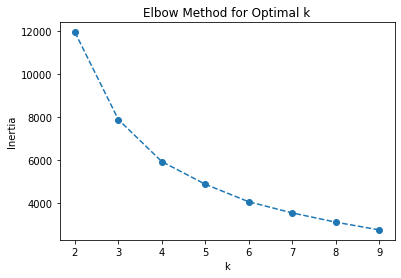

In [853]:
plt.plot(range(2, 10), elbow, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.ylabel('Inertia')
plt.xlabel('k');

In [854]:
kmeans = KMeans(init='k-means++', n_clusters=3)
clusters_customers = kmeans.fit_predict(pca_customer_profile)

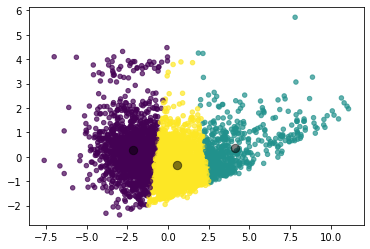

In [855]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7)
# select cluster centers
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

In [856]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,2,0,1
CustomersNb,1701,1455,526


For comparison, if we run only the k-means algorithm without the PCA step, the result would be the following:

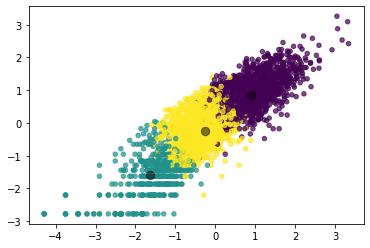

In [857]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7)
# select cluster centers
centroids = pca.inverse_transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=70, alpha=0.5);

## Fuzzy C-Means

In [858]:
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.fcm import fcm

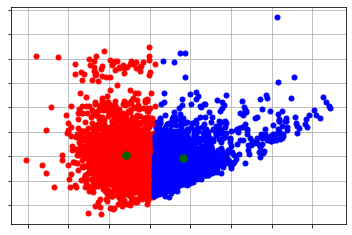

In [859]:
# initialize
initial_centers = kmeans_plusplus_initializer(pca_customer_profile, 2, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(pca_customer_profile, initial_centers)
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

# visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, pca_customer_profile, markersize=10)
visualizer.append_cluster(centers, markersize=15)
visualizer.show();

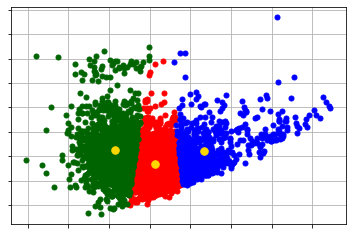

In [860]:
# initialize
initial_centers = kmeans_plusplus_initializer(pca_customer_profile, 3, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(pca_customer_profile, initial_centers)
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

# visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, pca_customer_profile, markersize=10)
visualizer.append_cluster(centers, markersize=15)
visualizer.show();

## DBSCAN

We can calculate the distance from each point to its closest neighbour using the K-nearest neighbors. The point itself is included in *n_neighbors*. The Knn method returns two arrays, one which contains the distance to the closest *n_neighbors* points and the other which contains the index for each of those points. The optimal value for *eps* will be found at the point of maximum curvature.

In [861]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

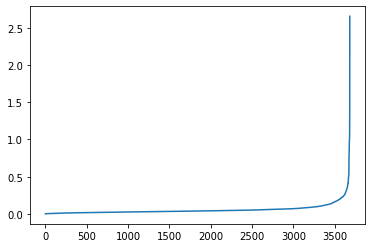

In [862]:
knn = NearestNeighbors(n_neighbors=10)
nbrs = knn.fit(pca_customer_profile)
distances, indices = nbrs.kneighbors(pca_customer_profile)
distances = np.sort(distances, axis=0)[:,1]
plt.plot(distances);

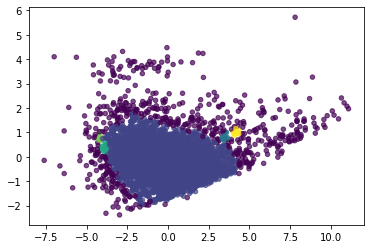

In [863]:
dbscan = DBSCAN(eps=0.2, min_samples=9)
clusters_customers = dbscan.fit_predict(pca_customer_profile)
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [864]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0,-1,2,1,4,3
CustomersNb,3075,560,15,14,10,8


For comparison, if we run only the DBSCAN algorithm without the PCA step, the result would be the following:

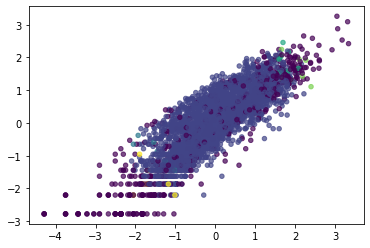

In [865]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

## Agglomerative Clustering

In [866]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion:

- *Ward* minimizes the euclidean distance of the clusters being merged (is the hierarchical analogue of K-means, so it can be used to initialize it)
    - strength: less susceptible to noise and outliers
    - limitations: biased towards globular clusters
- *single* or *maximum linkage* uses the minimum of the distances between all observations of the two sets
    - strength: can handle non-elliptical shapes
    - limitations: sensitive to noise and outliers
- *complete* or *maximum linkage* uses the maximum distances between all observations of the two sets
    - strength: less susceptible to noise and outliers
    - limitations: tends to break large clusters, biased towards globular clusters
- *average* linkage is a compromise between *single* and *complete* linkage by using the average of the distances of each observation of the two sets
    - strength: less susceptible to noise and outliers
    - limitations: biased towards globular clusters

### Ward Linkage

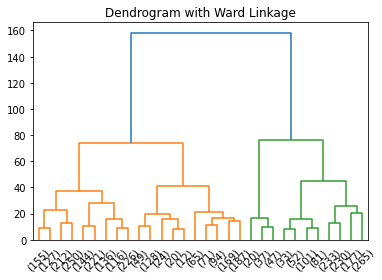

In [867]:
plt.title('Dendrogram with Ward Linkage')
ward_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='ward')), truncate_mode='lastp')

In [868]:
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

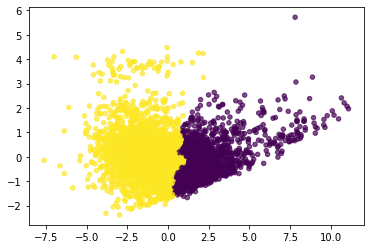

In [869]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [870]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,1,0
CustomersNb,2406,1276


For comparison, if we run only the agglomerative clustering algorithm with the Ward linkage without the PCA step, the result would be the following:

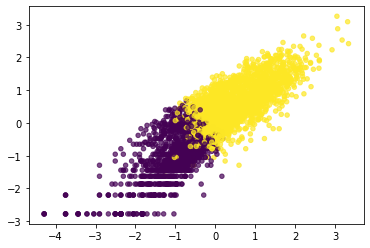

In [871]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

### Single Linkage

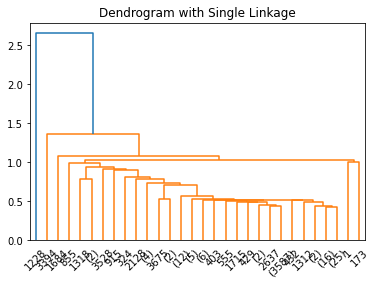

In [872]:
plt.title('Dendrogram with Single Linkage') 
min_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='single')), truncate_mode='lastp')

In [873]:
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='single')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

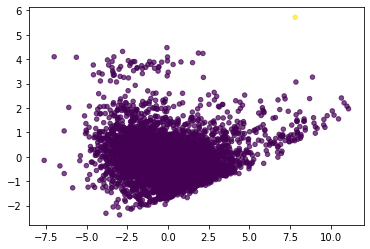

In [874]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [875]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0,1
CustomersNb,3681,1


For comparison, if we run only the agglomerative clustering algorithm with the single linkage without the PCA step, the result would be the following:

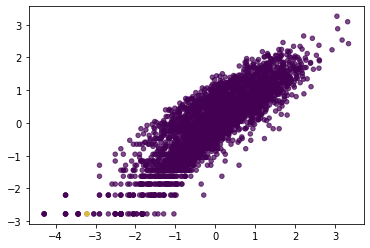

In [876]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

### Complete Linkage

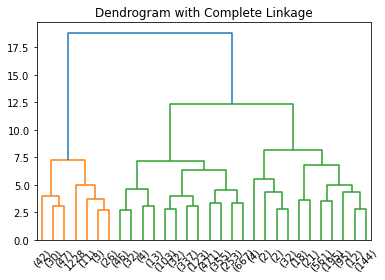

In [877]:
plt.title('Dendrogram with Complete Linkage') 
max_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='complete')), truncate_mode='lastp')

In [878]:
agglomerative = AgglomerativeClustering(n_clusters=2, linkage='complete')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

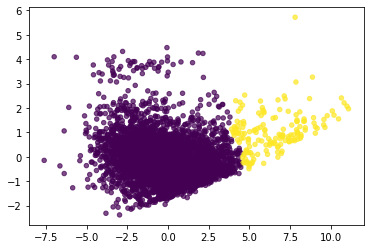

In [879]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [880]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,0,1
CustomersNb,3522,160


For comparison, if we run only the agglomerative clustering algorithm with the complete linkage without the PCA step, the result would be the following:

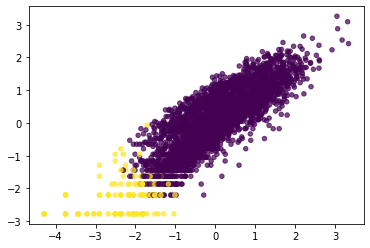

In [881]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

### Average Linkage

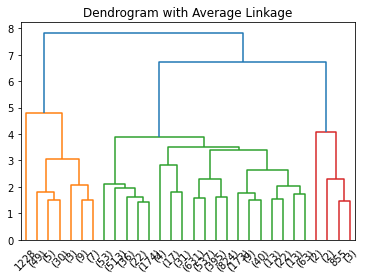

In [882]:
plt.title('Dendrogram with Average Linkage') 
avg_dendo = shc.dendrogram((shc.linkage(pca_customer_profile, method ='average')), truncate_mode='lastp')

In [883]:
agglomerative = AgglomerativeClustering(n_clusters=3, linkage='average')
clusters_customers = agglomerative.fit_predict(pca_customer_profile)

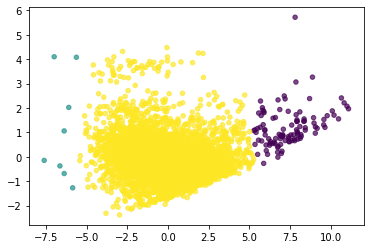

In [884]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [885]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,2,0,1
CustomersNb,3570,104,8


For comparison, if we run only the agglomerative clustering algorithm with the average linkage without the PCA step, the result would be the following:

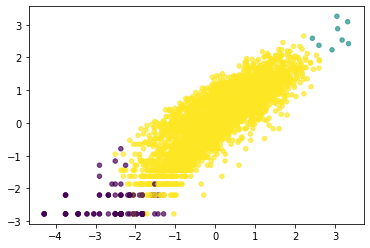

In [886]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

## Birch

In [887]:
from sklearn.cluster import Birch 

In [888]:
silhouette = []
for k in range(2, 10):
    birch = Birch(n_clusters=k)
    clusters = birch.fit_predict(pca_customer_profile)
    silhouette.append(silhouette_score(pca_customer_profile, clusters))

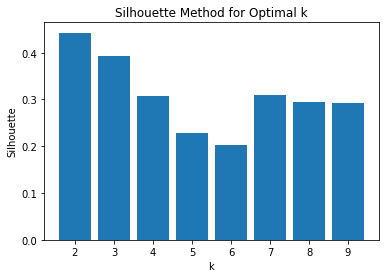

In [889]:
plt.bar(range(2, 10), silhouette)
plt.title('Silhouette Method for Optimal k')
plt.ylabel('Silhouette')
plt.xlabel('k');

In [890]:
print('The best silhouette score is:', max(silhouette))

The best silhouette score is: 0.44267909785137105


In [891]:
birch = Birch(n_clusters=2)
clusters_customers = birch.fit_predict(pca_customer_profile)

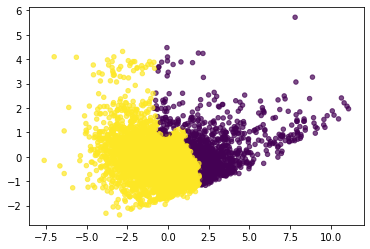

In [892]:
# create a scatter plot
plt.scatter(pca_customer_profile[:, 0], pca_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [893]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T

,1,0
CustomersNb,2832,850


For comparison, if we run only the agglomerative clustering algorithm with the single linkage without the PCA step, the result would be the following:

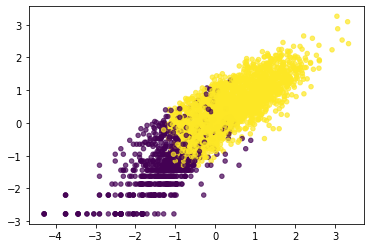

In [894]:
# create a scatter plot
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);